# Библиотеки

In [37]:
import neptune
import cv
import model_selection
import nn_model
import nn_training
import preprocessing
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
from sklearn.metrics import f1_score
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
rcParams['figure.figsize'] = 20, 10

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
neptune.init('iliaavilov/Magnit-test')

Project(iliaavilov/Magnit-test)

# Константы

In [4]:
random_state = 54321
data_path = 'data/'

# Загрузка данных

In [5]:
data = pd.read_csv('{}data_classification_for_task.csv'.format(data_path))

# EDA

In [6]:
data.head()

,AGE,GENDER,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,TARGET
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AGE         303 non-null    int64  
 1   GENDER      303 non-null    int64  
 2   FEATURE_1   303 non-null    int64  
 3   FEATURE_2   303 non-null    int64  
 4   FEATURE_3   303 non-null    int64  
 5   FEATURE_4   303 non-null    int64  
 6   FEATURE_5   303 non-null    int64  
 7   FEATURE_6   303 non-null    int64  
 8   FEATURE_7   303 non-null    int64  
 9   FEATURE_8   303 non-null    float64
 10  FEATURE_9   303 non-null    int64  
 11  FEATURE_10  303 non-null    int64  
 12  FEATURE_11  303 non-null    int64  
 13  TARGET      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
for col in data.columns:
    print('Уникальных значений в колонке {}'.format(col), len(data[col].unique()))

Уникальных значений в колонке AGE 41
Уникальных значений в колонке GENDER 2
Уникальных значений в колонке FEATURE_1 4
Уникальных значений в колонке FEATURE_2 49
Уникальных значений в колонке FEATURE_3 152
Уникальных значений в колонке FEATURE_4 2
Уникальных значений в колонке FEATURE_5 3
Уникальных значений в колонке FEATURE_6 91
Уникальных значений в колонке FEATURE_7 2
Уникальных значений в колонке FEATURE_8 40
Уникальных значений в колонке FEATURE_9 3
Уникальных значений в колонке FEATURE_10 5
Уникальных значений в колонке FEATURE_11 4
Уникальных значений в колонке TARGET 2


Отделим категориальные колонки от непрерывных

In [9]:
cont_vars = ['AGE', 'FEATURE_2', 'FEATURE_3', 'FEATURE_6', 'FEATURE_8']
cat_vars = [col for col in data.columns if col not in cont_vars]

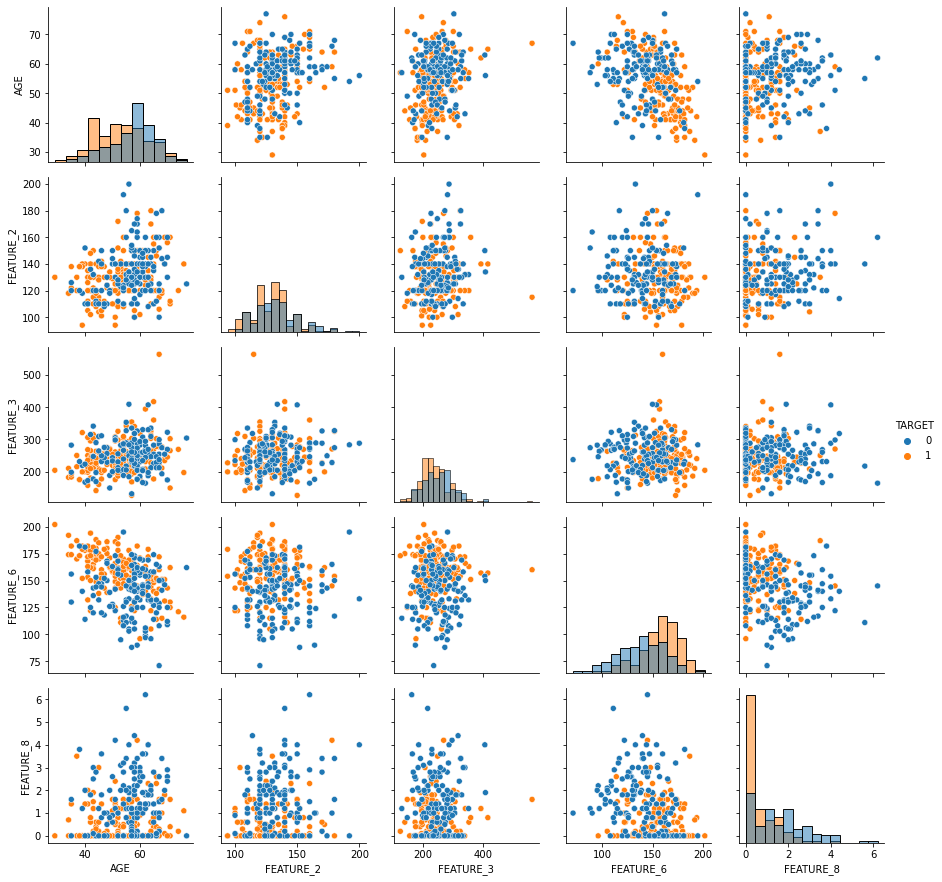

In [10]:
g = sns.PairGrid(data, vars = cont_vars, hue="TARGET")
_ = g.map_diag(sns.histplot)
_ = g.map_offdiag(sns.scatterplot)
_ = g.add_legend()

На некоторых графиках видны намеки на нелинейную границу разделения классов (например график AGE-FEATURE_6)\

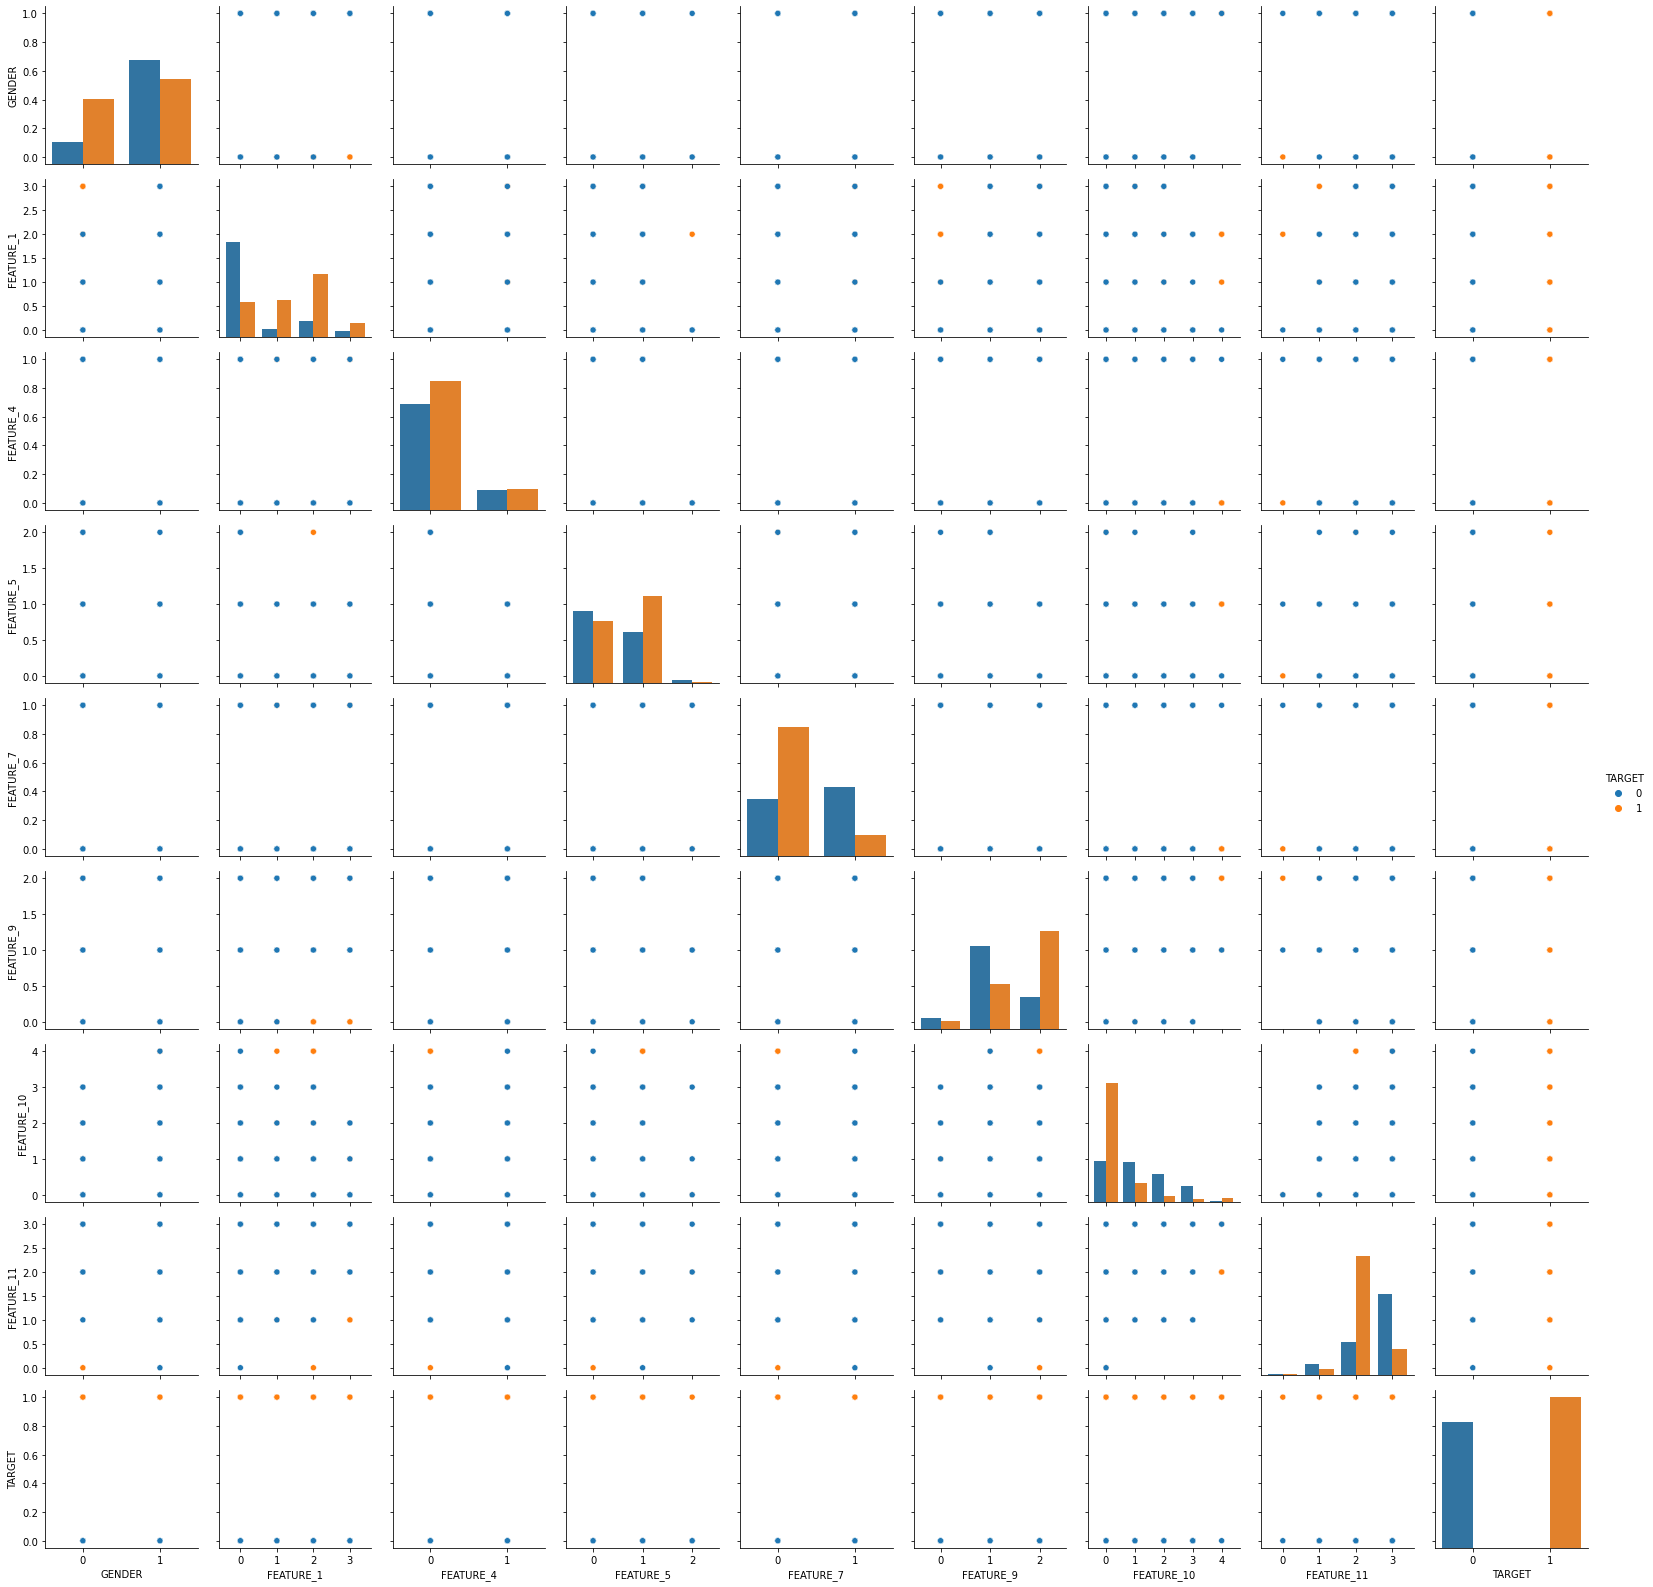

In [11]:
g = sns.PairGrid(data, vars = cat_vars, hue="TARGET")
_ = g.map_diag(sns.countplot)
_ = g.map_offdiag(sns.scatterplot)
_ = g.add_legend()

В некоторых сочетаниях категориальных переменных один класс встречается чаще другого, так что это тоже может помочь модели.

Классы почти сбалансированные, но все равно проведем стратифицированной сэмплирование при отборе отложенной, тестовой и валидационной выборок

In [12]:
data['TARGET'].value_counts()

1    165
0    138
Name: TARGET, dtype: int64

# Валидация

Будем проводить обычную Kfold валидацию на стратифицированных фолдах.\
В качестве отложенной выборки возьмем 20% от всех данных\
Из остальных данных нарежем 3 фолда, 2 из которых будут выступать в качестве валидационных, а третий в качестве тестового.

In [13]:
ss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = random_state)
cv_list = list(ss.split(data, data['TARGET']))
data_test = data.iloc[cv_list[0][1]]
data = data.iloc[cv_list[0][0]]

In [34]:
X = data_test.drop(['TARGET'], axis = 'columns')
y = data_test['TARGET']

In [36]:
# Получение индексов кросс валидации
cv_list = cv.get_indices_skf(X, y, n_splits = 3, random_state = random_state)

# Подбор модели

In [ ]:
%%capture
def params_func(trial, X):
    return(
        {
            # Метрика, которую будет минимизировать модель (использование другой функции потерь может помочь преодолеть 
            # локальные минимумы во время градиентного спуска)
            'objective': trial.suggest_categorical('objective', ['huber', 'fair', 'l2', 'l1', 'mape']), 
            # Метрика, которую будем минимизировать при подборе параметров
            'validation_loss': f1_score,
            'n_jobs': -1,
            # Максимальное кол-во итераций градиентного бустинга в lgbm
            'n_estimators': 1500,
            'early_stopping_rounds': 10,
            'random_state': random_state,
            # Категориальные фичи
            'categorical_feature': ['CONTRAGENT', 'ARTICLE_GROUP'],
            'feature_name': ['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SALES_PREVIOUS',
       'SALES_MEAN_DIFF_BEER', 'SALES_MEAN_DIFF_LIQUOR',
       'SALES_MEAN_DIFF_NON-ALCOHOL', 'SALES_MEAN_DIFF_REF',
       'SALES_MEAN_DIFF_STR_SUPPLIES', 'SALES_MEAN_DIFF_WINE',
       'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR',
       'SALES_SUM_DIFF_NON-ALCOHOL', 'SALES_SUM_DIFF_REF',
       'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE',
       'SALES_TOTAL_PREVIOUS_BEER', 'SALES_TOTAL_PREVIOUS_LIQUOR',
       'SALES_TOTAL_PREVIOUS_NON-ALCOHOL', 'SALES_TOTAL_PREVIOUS_REF',
       'SALES_TOTAL_PREVIOUS_STR_SUPPLIES', 'SALES_TOTAL_PREVIOUS_WINE'],
            # На какой подвыборке будет обучаться каждое дерево
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 1),
            # На какой подвыборке фичей будет обучаться каждое дерево
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1),
            # Минимальное количество наблюдений в листах деревьев (ставим много, т.к. переобучение будет контролировать
            # количеством листов)
            'min_child_samples': 10**1000,
            # Максимальное количество листов в каждом дереве
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.5)
        }
    )

# Инициализируем класс, подбирающий параметры
# n_trials - сколько будет попыток при выборе параметров, оптимизирующих метрику
# optuna.samplers.TPESampler сэмплировать параметры будем с помощью tree parzen estimator
my_training = model_selection.training(direction = 'minimize', model = 'lgbm',
                                       params_func = params_func, n_trials = 50,
                                       random_state = random_state, sampler = optuna.samplers.TPESampler)
# Инициализируем эксперимент на neptune.ai
my_training.initiate_neptune_exp(name = 'LGBM', 
                                 description = 
                                "['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SALES_MEAN_DIFF_BEER',\
       'SALES_MEAN_DIFF_LIQUOR', 'SALES_MEAN_DIFF_NON-ALCOHOL',\
       'SALES_MEAN_DIFF_REF', 'SALES_MEAN_DIFF_STR_SUPPLIES',\
       'SALES_MEAN_DIFF_WINE', 'SALES_PREVIOUS_BEER', 'SALES_PREVIOUS_LIQUOR',\
       'SALES_PREVIOUS_NON-ALCOHOL', 'SALES_PREVIOUS_REF',\
       'SALES_PREVIOUS_STR_SUPPLIES', 'SALES_PREVIOUS_WINE',\
       'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR',\
       'SALES_SUM_DIFF_NON-ALCOHOL', 'SALES_SUM_DIFF_REF',\
       'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE'] + все товары (без удаления товаров с нулевыми продажами)"
                                )

# Находим оптимальные параметры
my_training.train(X = X, 
                  y = y, 
                  cv = cv_list)

# Результаты:

In [58]:
pd.read_csv('lgbm_results.csv')

,Id,logs/best_so_far_run_score (last),logs/metric_std_cv (last),Description,logs/metric_test (last)
0,MAG-31,3237.774761,4299.995501,"['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SAL...",345.403797
1,MAG-30,2319.033173,3051.756413,"['ARTICLE_GROUP', 'VOLUME', 'SALES_MEAN_DIFF_B...",248.887528
2,MAG-29,2323.507791,3167.771004,"['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SAL...",217.199758


Mag-29. Обучение на всех колонках со всеми данными (без удаления товаров с постоянно нулевыми продажами)\
Mag-30. Обучение без CONTRAGENT (была гипотеза, что модель переобучается из за нее) со всеми данными (без удаления товаров с постоянно нулевыми продажами)\
Mag-31. Обучение на всех колонках только с товарами, у которых есть ненулевые продажи

Дроп CONTRAGENT не повлиял на результаты модели.\
При дропе товаров с нулевыми продажами результат модели ухудшился (но при дропе товаров с нулевыми родажами эти товары дропнулись и из тестовой части. Поправка на удаление этих нулевых товаров показала, что результат модели примерно соотвествует результату модели, обученной на всех данных). 

В среднем на валидационных фолдах (первые два фолда в cv_list) модель ошибается на 2300\
При этом стандартное отклонение между фолдами достаточно большое (~3000), то есть модель показывает разные результьаты на двух разных фолдах.\
На тестовой части (она не использовалась ни при обучении модели, ни при подборе параметров) модель ошибается на ~250, что можно назвать приличным результатов (среднее таргета 6580, предсказание средним дает значение метрики ~9200)

Обучим модель на подобранных параметрах

In [90]:
params = {'objective': 'l1',
          'n_jobs': -1, 
          'n_estimators': 27, 
          'random_state': 54321, 
          'bagging_fraction': 0.3152994540674175, 
          'feature_fraction': 0.9922704237794605, 
          'min_child_samples': 10**100,
          'num_leaves': 140, 
          'learning_rate': 0.23253552427140564}

In [91]:
categorical_feature = ['CONTRAGENT', 'ARTICLE_GROUP'] 
feature_name = ['CONTRAGENT', 'ARTICLE_GROUP', 'VOLUME', 'SALES_PREVIOUS', 
                'SALES_MEAN_DIFF_BEER', 'SALES_MEAN_DIFF_LIQUOR', 
                'SALES_MEAN_DIFF_NON-ALCOHOL', 'SALES_MEAN_DIFF_REF', 
                'SALES_MEAN_DIFF_STR_SUPPLIES', 'SALES_MEAN_DIFF_WINE', 
                'SALES_SUM_DIFF_BEER', 'SALES_SUM_DIFF_LIQUOR', 'SALES_SUM_DIFF_NON-ALCOHOL', 
                'SALES_SUM_DIFF_REF', 'SALES_SUM_DIFF_STR_SUPPLIES', 'SALES_SUM_DIFF_WINE', 
                'SALES_TOTAL_PREVIOUS_BEER', 'SALES_TOTAL_PREVIOUS_LIQUOR', 'SALES_TOTAL_PREVIOUS_NON-ALCOHOL',
                'SALES_TOTAL_PREVIOUS_REF', 'SALES_TOTAL_PREVIOUS_STR_SUPPLIES', 'SALES_TOTAL_PREVIOUS_WINE']

Обучаем на всех данных, кроме последнего месяца

In [92]:
train_data = lgb.Dataset(data[data['DATE']!= '2018-02-01'].drop(['DATE', 'SALES', 'ARTICLE_NAME'], axis = 'columns'),
                         data[data['DATE']!= '2018-02-01']['SALES'], 
                         feature_name = feature_name, 
                         categorical_feature = categorical_feature)

In [93]:
model = lgb.train(params = params,
                  train_set = train_data,
                  verbose_eval = False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 706
[LightGBM] [Info] Number of data points in the train set: 66145, number of used features: 22
[LightGBM] [Info] Start training from score 410.000000


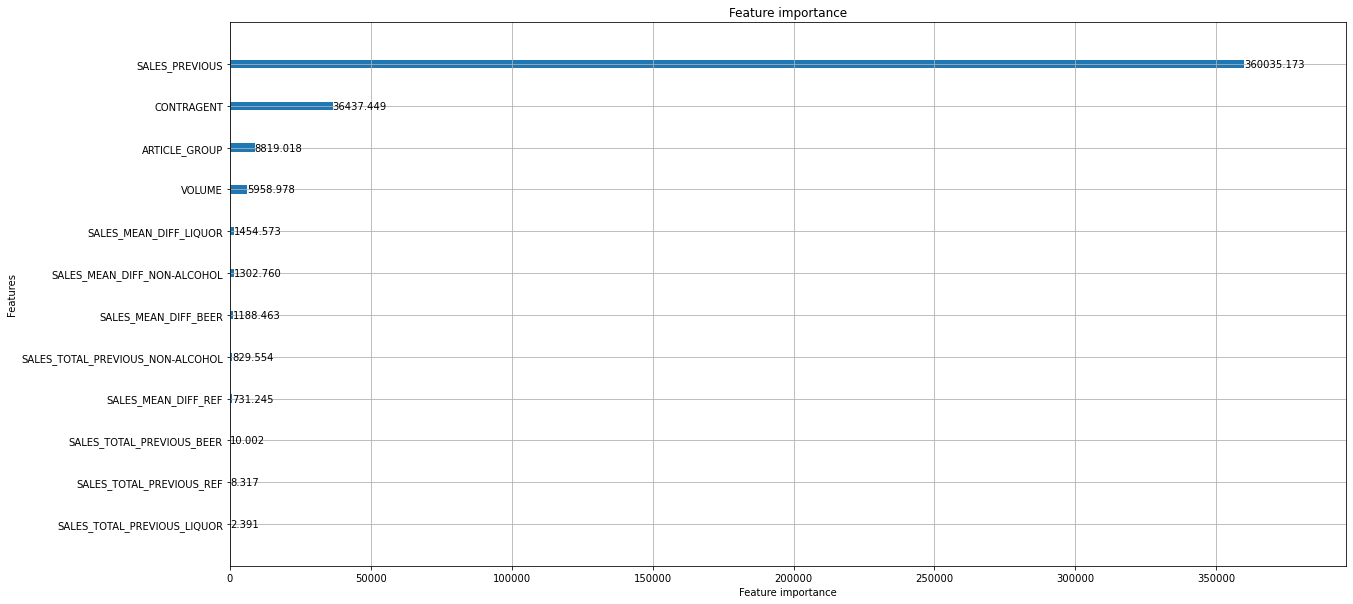

In [94]:
_ = lgb.plot_importance(model, importance_type = 'gain')

Самой полезной фичой как и ожидалось оказлась информация о продажах товара в предыдущий месяц\
Информация о контрагенте на удивление тоже оказалась полезной\
Информация о группе товаров также ожидаемо оказалась полезной\
Не зря извлекли информацию об объеме, она тоже сильно докинула\
Остальные фичи гораздо менее полезные

Делаем предсказания для последнего месяца (а там, где ['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS'] предсказываем 0)

In [63]:
data_test = data_test.reset_index(drop = True)

In [69]:
test_predictions = data[data['DATE']== '2018-02-01']
test_predictions['ARTICLE_GROUP'] = test_predictions['ARTICLE_GROUP'].astype(float)

In [70]:
predictions = model.predict(test_predictions.drop(['DATE', 'SALES', 'ARTICLE_NAME'], axis = 'columns'))
test_predictions['predictions'] = predictions

In [71]:
data_test['predictions'] = None

In [73]:
data_test = data_test[data_test['ARTICLE_GROUP'].isin(['DUNNAGE', 'KEGS'])].append(test_predictions)

In [75]:
data_test['predictions'] = data_test['predictions'].fillna(0)

Значение MAE

In [76]:
metric(data_test['SALES'], data_test['predictions'])

2485.060045225739

Значение предложенной метрики

In [77]:
metric_suggested(data_test['SALES'], data_test['predictions'])

43.030859631215236

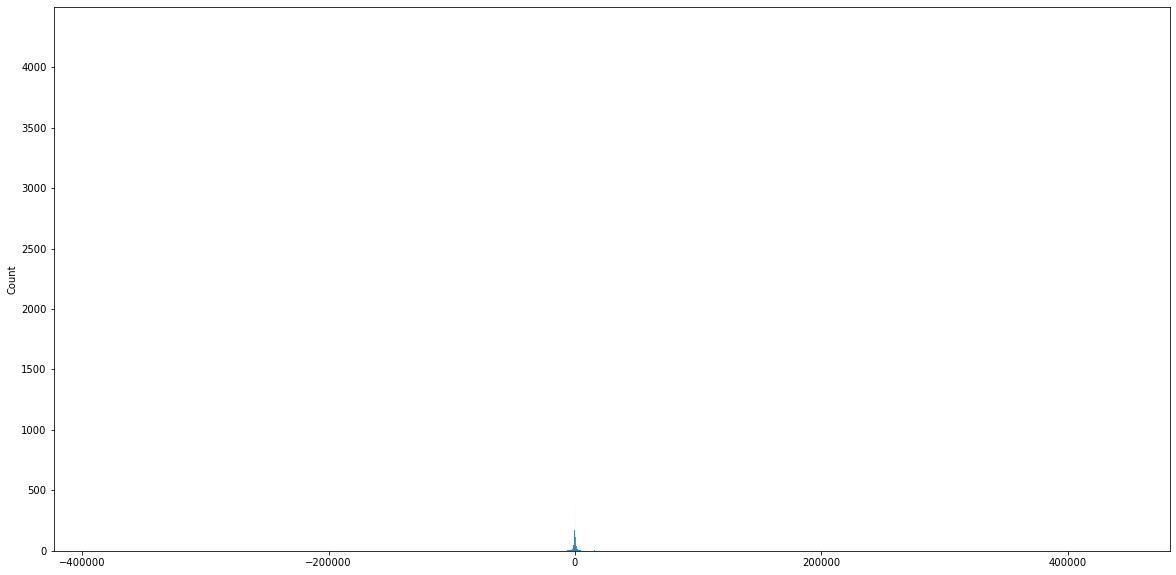

In [79]:
_ = sns.histplot(data_test['SALES']-data_test['predictions'])

В среднем ошибка модель ошибается несильно, но при этом для некоторых товаров предсказания сильно отличаются от реальности\
Это все те же популярные товары с большими объемами продаж

In [81]:
data_test['error'] = (data_test['SALES']-data_test['predictions'])

In [82]:
data_test.sort_values('error', ascending = False)

,CONTRAGENT,ARTICLE_NAME,ARTICLE_GROUP,SALES,VOLUME,DATE,SALES_PREVIOUS,SALES_MEAN_DIFF_BEER,SALES_MEAN_DIFF_LIQUOR,SALES_MEAN_DIFF_NON-ALCOHOL,...,SALES_SUM_DIFF_WINE,SALES_TOTAL_PREVIOUS_BEER,SALES_TOTAL_PREVIOUS_LIQUOR,SALES_TOTAL_PREVIOUS_NON-ALCOHOL,SALES_TOTAL_PREVIOUS_REF,SALES_TOTAL_PREVIOUS_STR_SUPPLIES,SALES_TOTAL_PREVIOUS_WINE,predictions_lgbm,predictions,error
67853,66,CORONA EXTRA LOOSE NR - 12OZ,0,973000.0,354.8820,2018-02-01,665000.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,531526.151084,441473.848916
75123,102,TITO'S HANDMADE VODKA - 1.75L,1,983020.0,1750.0000,2018-02-01,634760.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,641144.306493,341875.693507
68391,40,JACK DANIELS BLACK - 1.75L,1,416430.0,1750.0000,2018-02-01,226990.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,212337.566154,204092.433846
68620,144,CANADIAN CLUB WHISKEY - 1.75L,1,190390.0,1750.0000,2018-02-01,NaN,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,3120.353448,187269.646552
68329,15,STELLA ARTOIS LOOSE NR - 11.2OZ,0,402000.0,331.2232,2018-02-01,291000.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,246073.564398,155926.435602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73070,25,BACARDI RUM - LIGHT - 1.75L,1,182640.0,1750.0000,2018-02-01,328290.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,331361.028131,-148721.028131
76703,74,YELLOW TAIL MERLOT - 750ML,5,25900.0,750.0000,2018-02-01,169980.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,178384.574380,-152484.574380
75066,74,YELLOW TAIL CAB - 750ML,5,22350.0,750.0000,2018-02-01,178850.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,178384.574380,-156034.574380
73469,74,JOSH CELLARS CAB - 750ML,5,49950.0,750.0000,2018-02-01,252340.0,-2700.350633,-2289.346345,-3456.345746,...,-8483200.0,16606330.0,28579870.0,732250.0,23660.0,56940.0,29792720.0,NaN,218208.075872,-168258.075872
